# Basics of computing sentiment for Reddit headlines

In this notebook, I am outlining a basic approach to computing sentiment for [Reddit](https://reddit.com) threads in a given subreddit. The analysis runs over a timespan that is specified by the notebook user.

This is an adaptation/modernization of a solution previously discussed [on LearnDataSci](https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/). 

In [1]:
import urllib.request
import json 
import datetime

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn

from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint
from IPython import display

We now need to download the lexicon for NLTK, that will be used to analyze the words extracted from Reddit titles. [VADER](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8109/8122) (Valence Aware Dictionary and sEntiment Reasoner) is used as the pre-trained model.

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dend/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Next, we pre-defined the style for Seaborn, the graphing library we will be using down the line.

In [3]:
seaborn.set(style='darkgrid', context='talk', palette='Dark2')

Now we can define a function that will use the PushShift API to pull in historical Reddit post information. We could use a library like [praw](https://praw.readthedocs.io/en/latest/), however it's capabilities are limited given some [Reddit API changes](https://stackoverflow.com/a/54046328/303696) that restrict timeframe-based lookups.

In [4]:
def load_results(lower_bound_timestamp, upper_bound_timestamp, target_result_size, target_subreddit, score_threshold):
    headline_collection = set()
    
    reddit_data_url = f"https://api.pushshift.io/reddit/submission/search/?after={lower_bound_timestamp}&before={upper_bound_timestamp}&sort_type=score&sort=desc&subreddit={target_subreddit}&size={target_result_size}&score={score_threshold}"
    
    try:
        with urllib.request.urlopen(reddit_data_url) as url:
            data = json.loads(url.read().decode())
            
            for submission in data['data']:
                headline_collection.add(submission['title'])

        return headline_collection
    except urllib.error.HTTPError as e:
        print(e.__dict__)
        return set()
    except urllib.error.URLError as e:
        print(e.__dict__)
        return set()

Next, we can perform a range of queries against the API to get sets of Reddit posts that match our criteria - coming from the `dotnet` subreddit, and with a score of more than 10. We are also starting the lookup at a date one year ago from today, and sliding the lookup window by 5 days in each call. Using `union()` for set merges ensures that we are not duplicating titles that we are inspecting.

In [5]:
headlines = set()

time_now = datetime.datetime.now()

limit_delta = 365
limit_lower_delta = 360

subreddit = "programming"
result_size = 1000
score_limit = ">10"

for i in range(0, 73):
    previous_timestamp = int((time_now - datetime.timedelta(days=limit_delta)).timestamp())
    current_timestamp = int((time_now - datetime.timedelta(days=limit_lower_delta)).timestamp())

    full_collection = load_results(previous_timestamp, current_timestamp, result_size, subreddit, score_limit)
    headlines = headlines.union(full_collection)
    
    limit_delta = limit_delta - 5
    limit_lower_delta = limit_lower_delta - 5
    
    display.clear_output()
    print(f"Cycle {i}")
    print(len(headlines))

Cycle 72
3821


To get the sentiment, we need to calculate the polarity scores for each line that we have in the set.

In [6]:
sia = SentimentIntensityAnalyzer()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:5], width=100)

[{'compound': 0.5106,
  'headline': 'I made a small little application that generates random parametric curves :3',
  'neg': 0.0,
  'neu': 0.732,
  'pos': 0.268},
 {'compound': 0.0,
  'headline': 'ISA Semantics for ARMv8-A, RISC-V, and CHERI-MIPS - POPL 2019',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.5106,
  'headline': 'SymPy makes math fun again',
  'neg': 0.0,
  'neu': 0.548,
  'pos': 0.452},
 {'compound': 0.0,
  'headline': 'A simpler approach to frontend development (no NPM)',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'Geting 4x Speedup With .NET Core 3.0 SIMD Intrinsics',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0}]


Converting the results to a data frame makes it much easier to operate, so we will do just that.

In [7]:
df = pd.DataFrame.from_records(results)
df.head()

neg    neu    pos  compound  \
0  0.0  0.732  0.268    0.5106   
1  0.0  1.000  0.000    0.0000   
2  0.0  0.548  0.452    0.5106   
3  0.0  1.000  0.000    0.0000   
4  0.0  1.000  0.000    0.0000   

                                            headline  
0  I made a small little application that generat...  
1  ISA Semantics for ARMv8-A, RISC-V, and CHERI-M...  
2                         SymPy makes math fun again  
3  A simpler approach to frontend development (no...  
4  Geting 4x Speedup With .NET Core 3.0 SIMD Intr...

Based on the compound assessed value, we can determine whether the headline that we are analyzing is positive or negative. We can label that accordingly with a `1` value for positive sentiment and `-1` value for negative sentiment.

In [8]:
df['label'] = 0
df.loc[df['compound'] > 0.1, 'label'] = 1
df.loc[df['compound'] < -0.1, 'label'] = -1
df.head()

neg    neu    pos  compound  \
0  0.0  0.732  0.268    0.5106   
1  0.0  1.000  0.000    0.0000   
2  0.0  0.548  0.452    0.5106   
3  0.0  1.000  0.000    0.0000   
4  0.0  1.000  0.000    0.0000   

                                            headline  label  
0  I made a small little application that generat...      1  
1  ISA Semantics for ARMv8-A, RISC-V, and CHERI-M...      0  
2                         SymPy makes math fun again      1  
3  A simpler approach to frontend development (no...      0  
4  Geting 4x Speedup With .NET Core 3.0 SIMD Intr...      0

Now, we can isolate the headlines and labels into a separate data frame, and store the data in a CSV file that we can work with later on - that way, it won't be necessary to re-download the content over and over again for every run.

In [9]:
working_dataframe = df[['headline', 'label']]
working_dataframe.to_csv('labeled-data-set.csv', mode='a', encoding='utf-8', index=False)

Let's take a look at what headlines we have.

In [10]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headline)[:20], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:20], width=200)

Positive headlines:

['I made a small little application that generates random parametric curves :3',
 'SymPy makes math fun again',
 "Worked in the software industry long enough to know that coding interviews don't measure a candidate's ability to succeed on the role - it's a shame that many companies still use it as a measuring "
 'standard. To bridge this gap, I started a YT series going over popular coding interview questions.',
 "Torvalds thoughts about Microsoft's proclaimed love for linux",
 'PyQt examples 2019: Learn to create a desktop app',
 'Dolphin Progress Report: June and July 2019',
 'RPCS PS3 Emulator - June 2019 Progress Report',
 'How Monoids are useful in Programming',
 'ASCII fluid dynamics -- A tiny fluid simulator that fits in 80x25 terminal',
 'pgsh: Branch your PostgreSQL Database like Git',
 'Math for Programmers is a (currently) free book in the Manning Early Access Program. Several chapters have been released',
 'Dave Cheney: Clear is better than clever',
 'V

Now, we want to generate a word cloud for both the negative and the positive headlines, to see if there are any frequently-occurring words. To do that, we will isolate the dataframe columns.

In [11]:
negative_titles = df[df['label'] == -1]
negative_titles.head()

neg    neu    pos  compound  \
17  0.185  0.734  0.081   -0.6239   
28  0.231  0.661  0.107   -0.5423   
40  0.391  0.489  0.120   -0.7184   
48  0.427  0.244  0.329   -0.2023   
51  0.277  0.563  0.160   -0.5423   

                                             headline  label  
17  I'm trying out a blog where I explain CS conce...     -1  
28  Ready for another fright? Spectre flaws in tod...     -1  
40  19 teenage Indian students commit suicide afte...     -1  
48                  Bitbucket kills Mercurial support     -1  
51  Excelsior JET is dead? Excelsior JET stops dev...     -1

With negative titles separate, we can now run that through `WordCloud` to get the rendering.

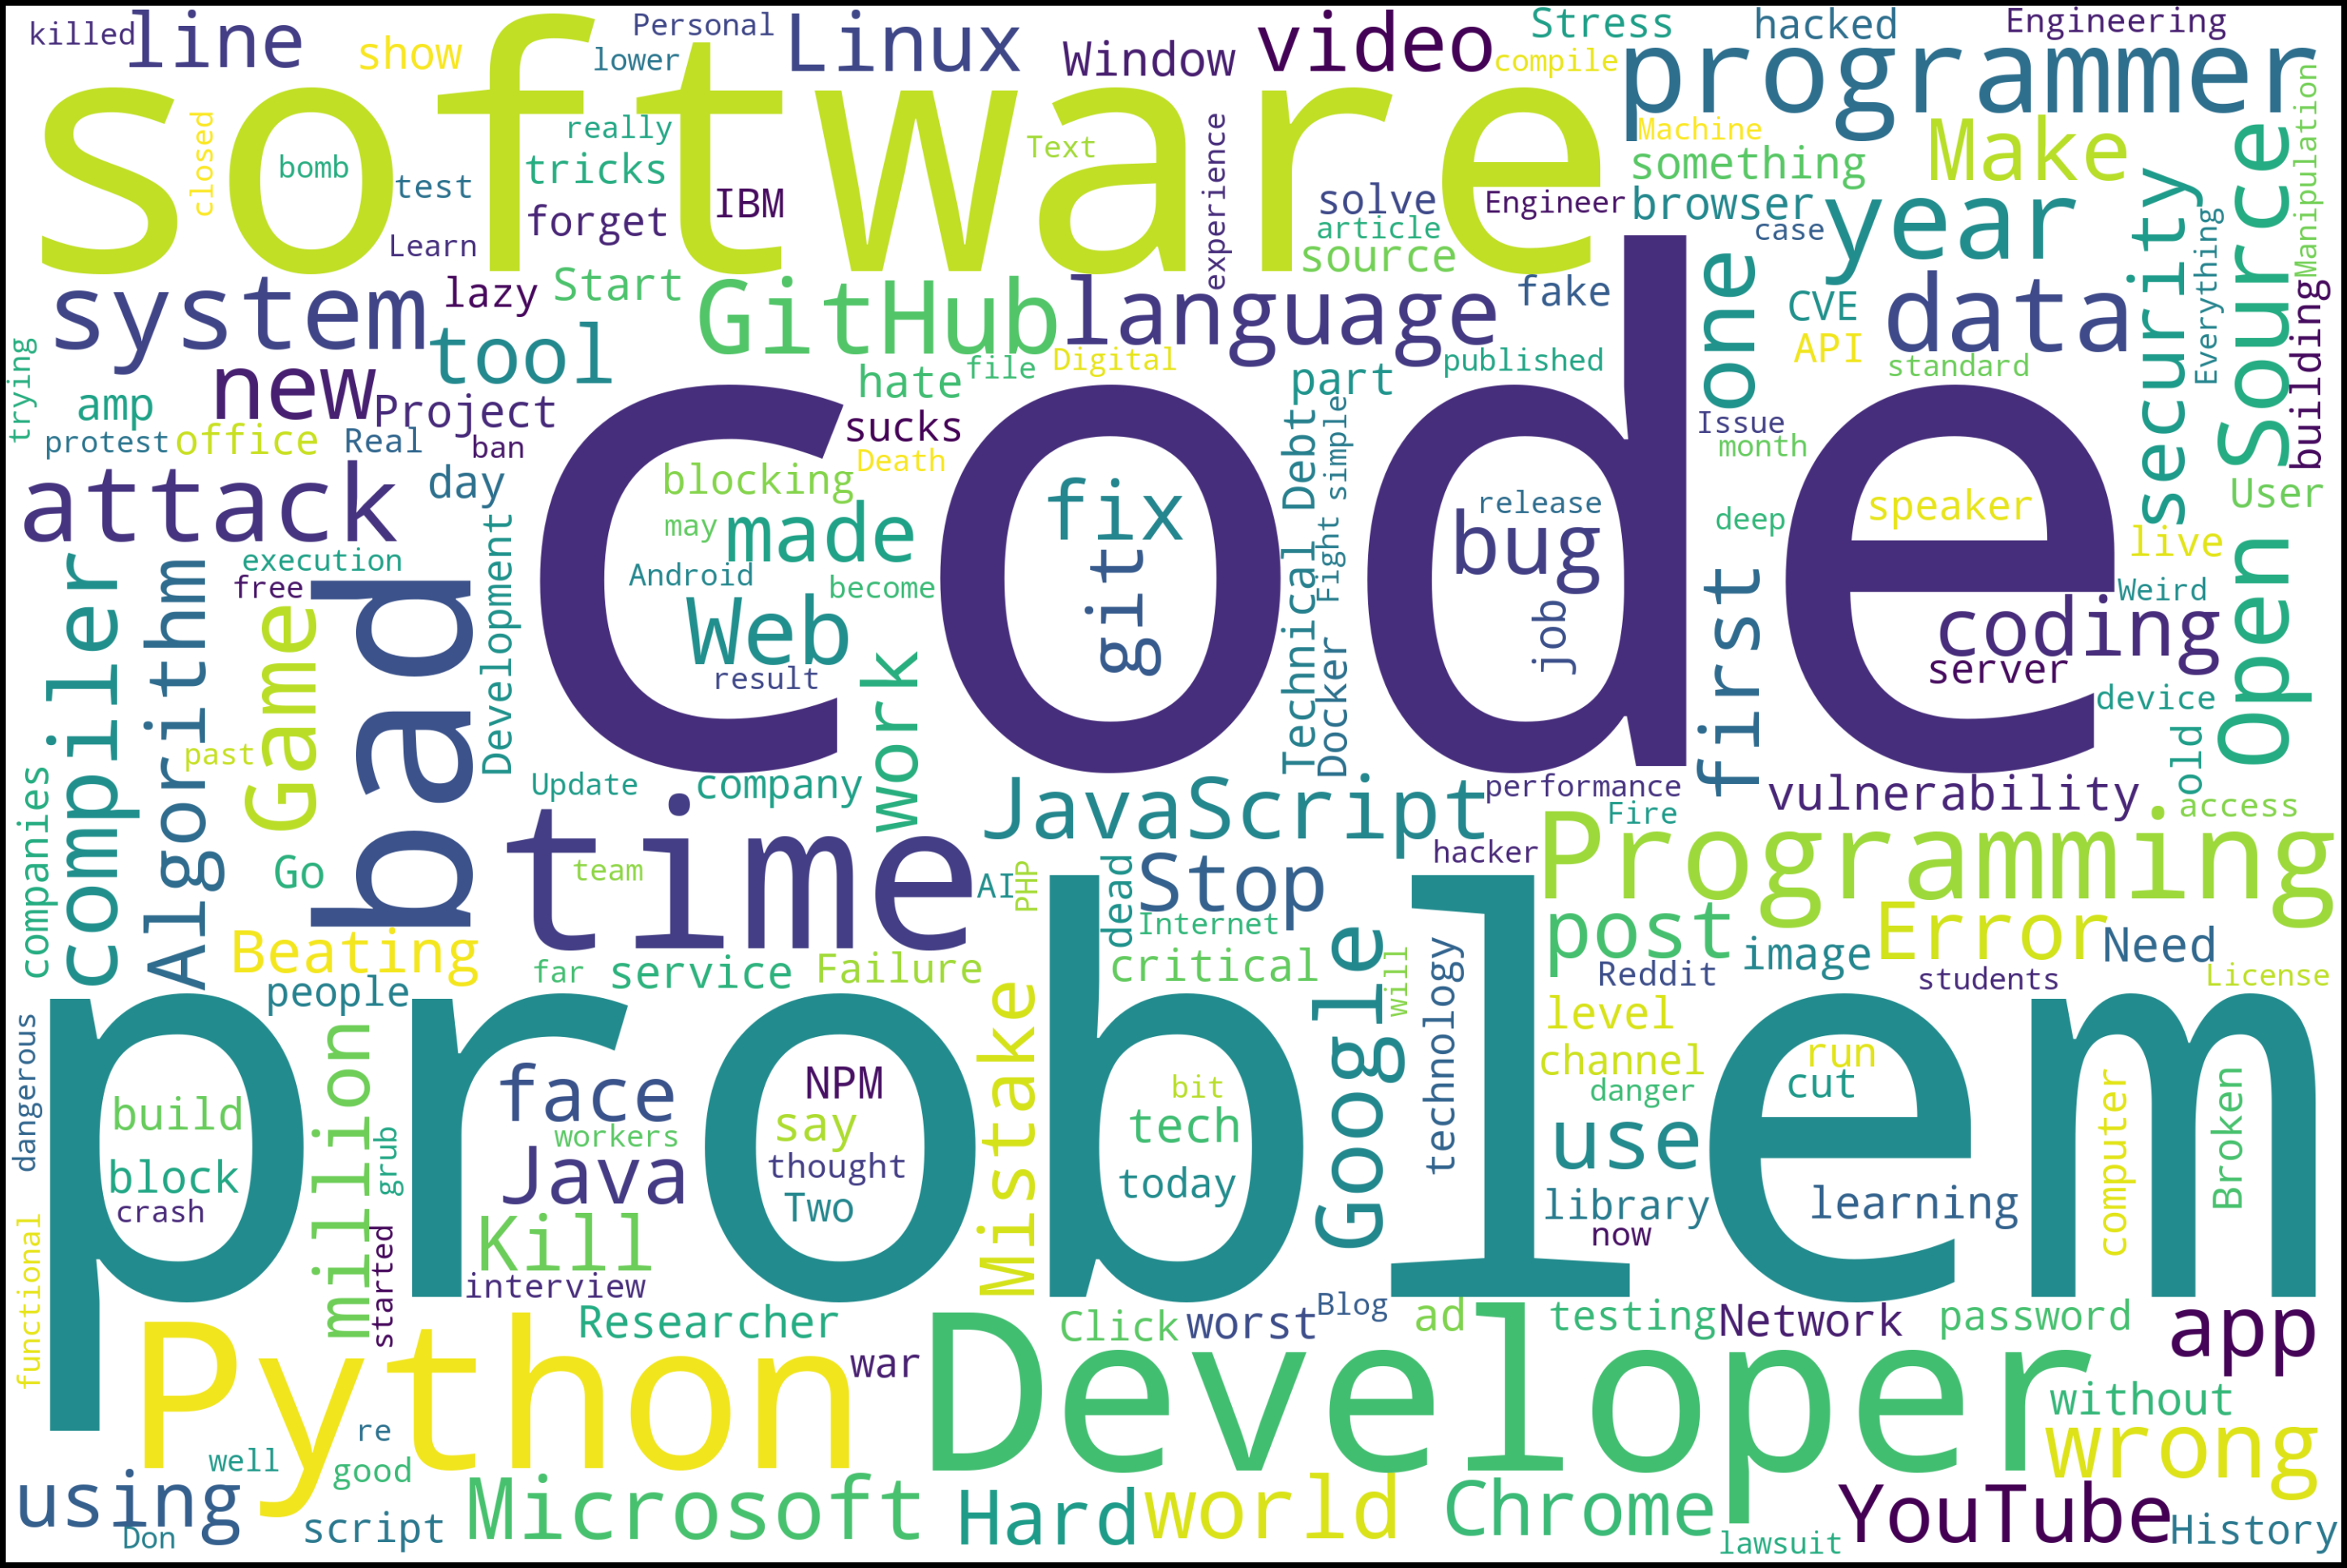

In [12]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(negative_titles['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We do the same isolation for positive titles.

In [13]:
positive_titles = df[df['label'] == 1]
positive_titles.head()

neg    neu    pos  compound  \
0  0.000  0.732  0.268    0.5106   
2  0.000  0.548  0.452    0.5106   
5  0.097  0.788  0.115    0.2354   
6  0.000  0.625  0.375    0.6369   
7  0.000  0.769  0.231    0.2732   

                                            headline  label  
0  I made a small little application that generat...      1  
2                         SymPy makes math fun again      1  
5  Worked in the software industry long enough to...      1  
6  Torvalds thoughts about Microsoft's proclaimed...      1  
7  PyQt examples 2019: Learn to create a desktop app      1

And render the cloud.

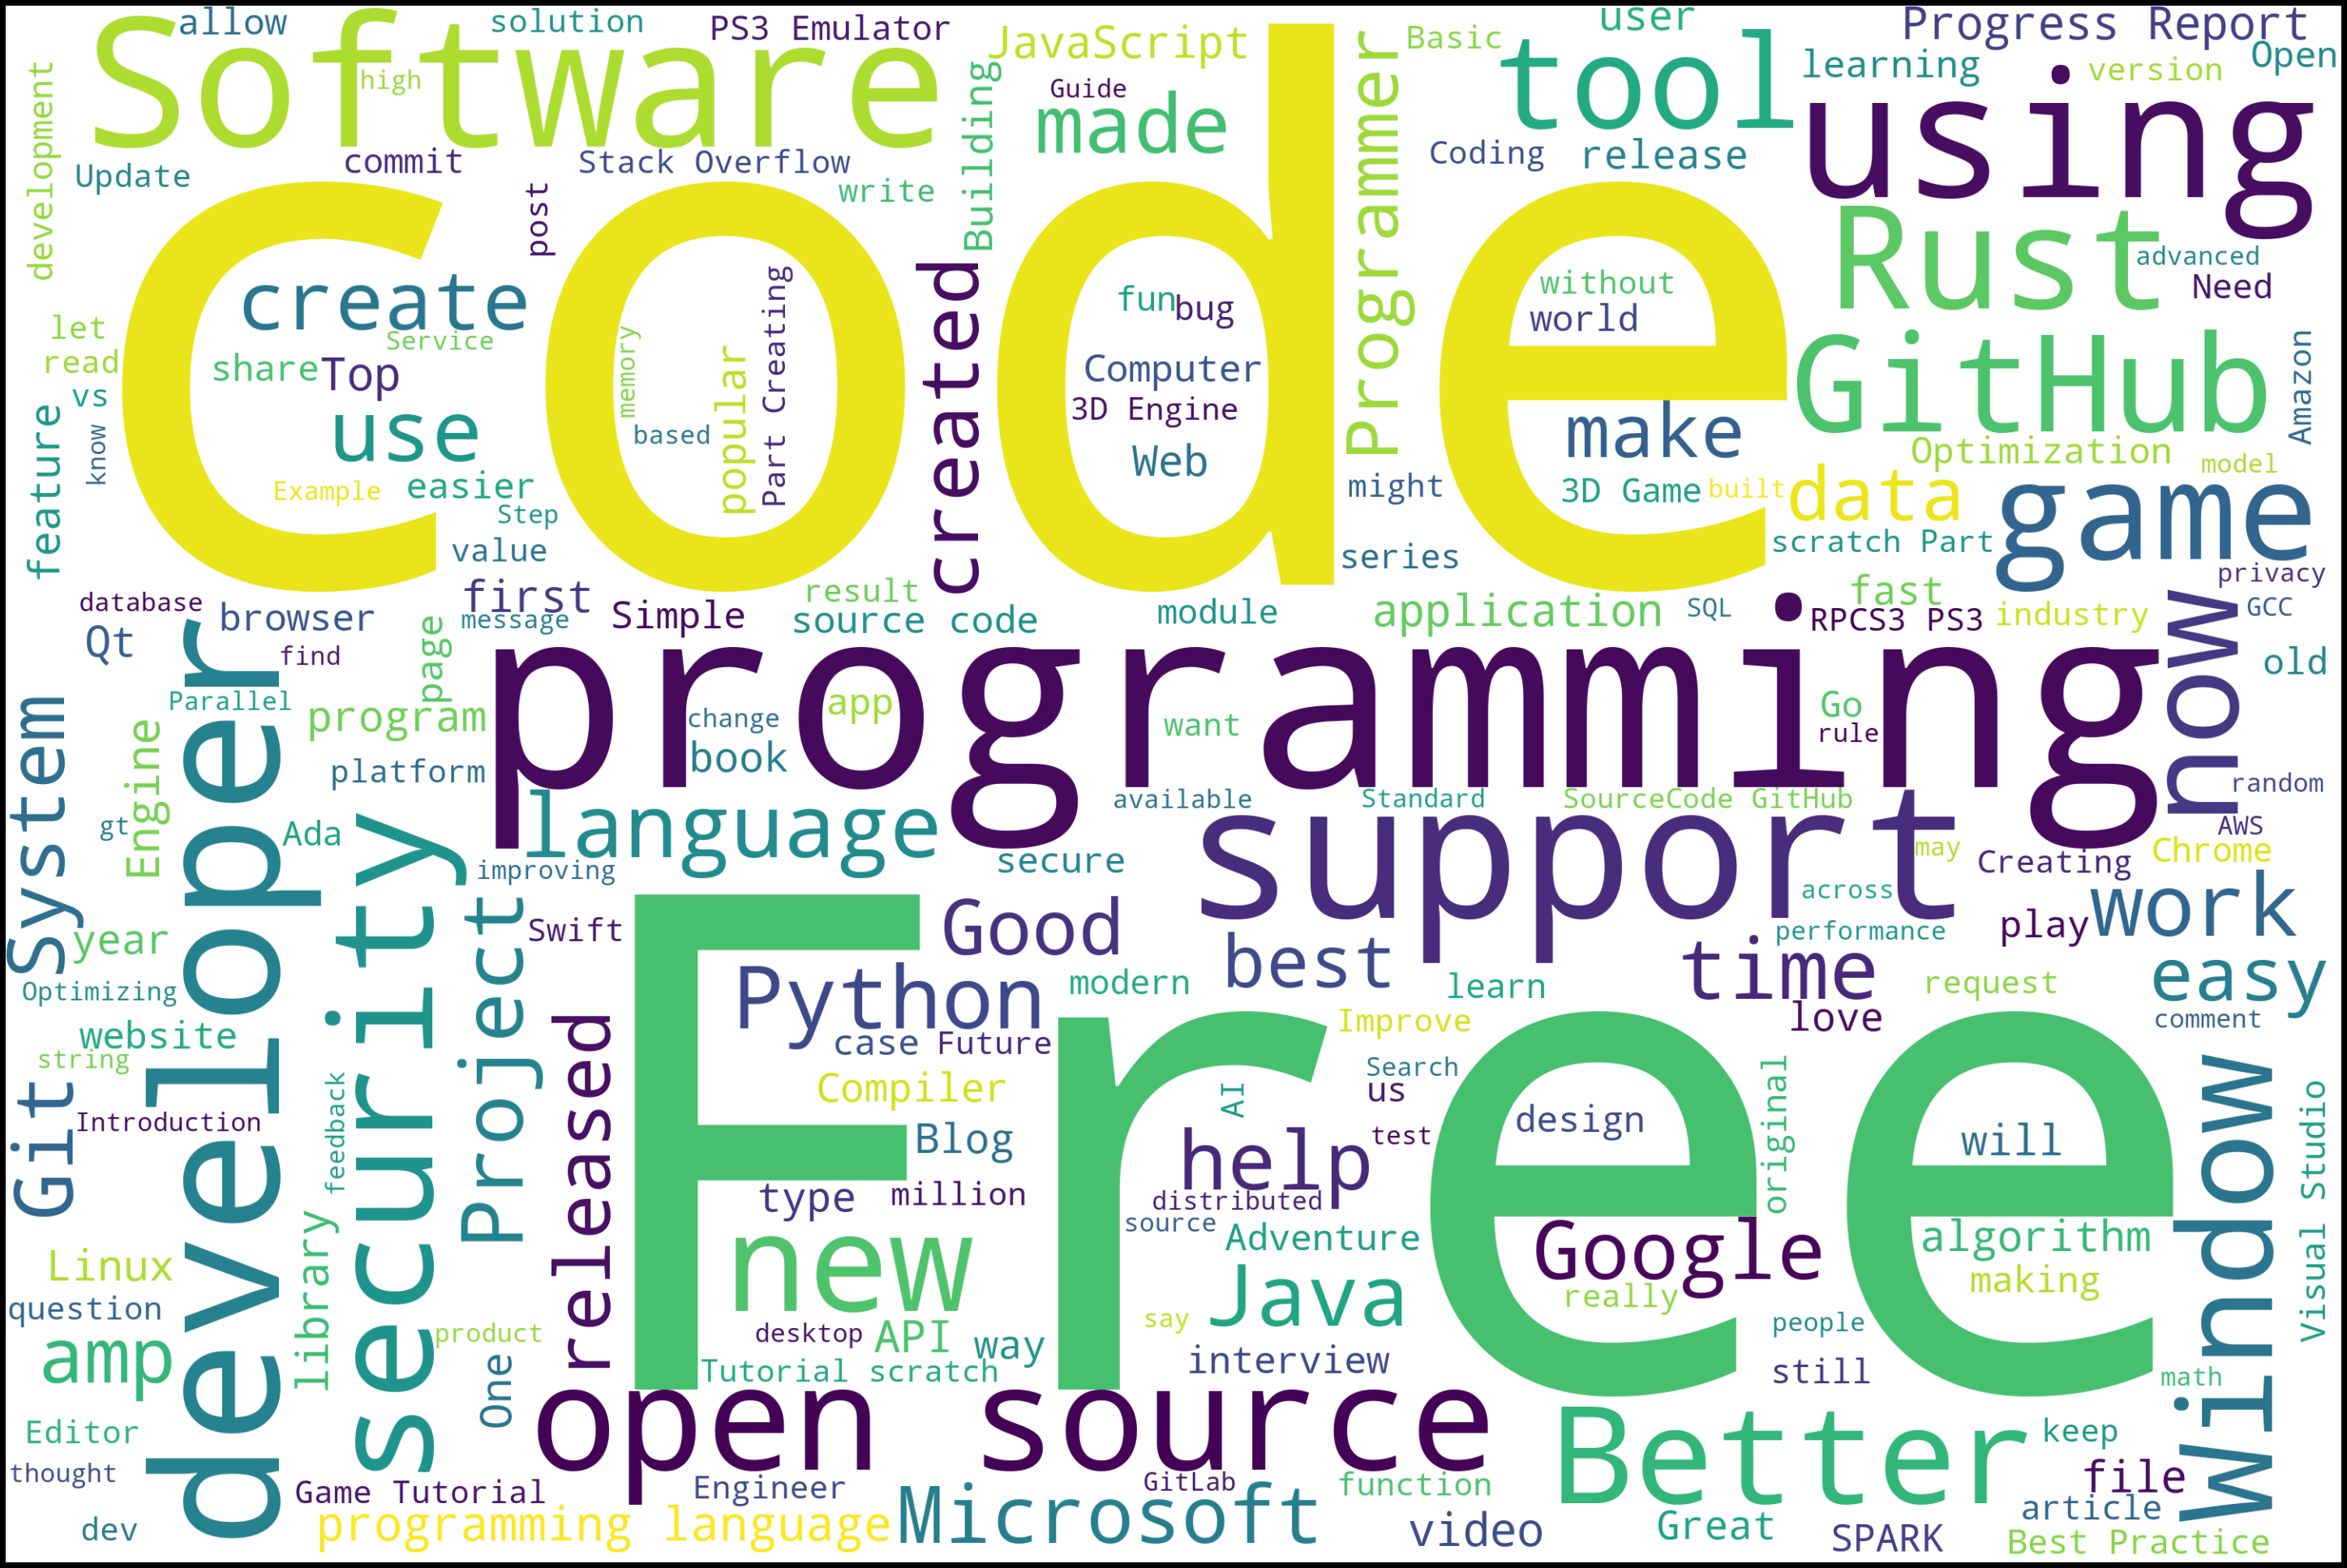

In [14]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(' '.join(positive_titles['headline']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Last but not least, we will calculate the counts of negative, neutral and positive titles in the set that we obtained.

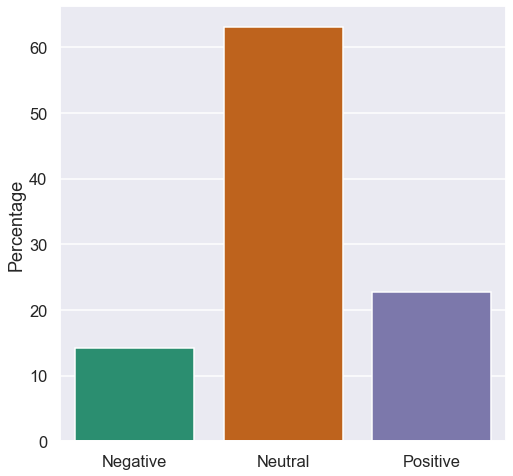

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

seaborn.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()